## Análisis inicial

In [2]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Para tokenización sin depender de 'punkt'
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud

# Para análisis de sentimiento con VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Para extracción de tópicos con LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Habilitar la visualización inline en Jupyter Notebook
%matplotlib inline

In [3]:
df = pd.read_csv("data/fifa_world_cup_2022_tweets.csv")

In [4]:
print(df.head())

   Unnamed: 0               Date Created  Number of Likes  \
0           0  2022-11-20 23:59:21+00:00                4   
1           1  2022-11-20 23:59:01+00:00                3   
2           2  2022-11-20 23:58:41+00:00                1   
3           3  2022-11-20 23:58:33+00:00                1   
4           4  2022-11-20 23:58:28+00:00                0   

       Source of Tweet                                              Tweet  \
0      Twitter Web App  What are we drinking today @TucanTribe \n@MadB...   
1   Twitter for iPhone  Amazing @CanadaSoccerEN  #WorldCup2022 launch ...   
2   Twitter for iPhone  Worth reading while watching #WorldCup2022 htt...   
3      Twitter Web App  Golden Maknae shinning bright\n\nhttps://t.co/...   
4  Twitter for Android  If the BBC cares so much about human rights, h...   

  Sentiment  
0   neutral  
1  positive  
2  positive  
3  positive  
4  negative  


In [5]:
df.columns = df.columns.str.strip()
print(df.columns)

Index(['Unnamed: 0', 'Date Created', 'Number of Likes', 'Source of Tweet',
       'Tweet', 'Sentiment'],
      dtype='object')


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22524 entries, 0 to 22523
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       22524 non-null  int64 
 1   Date Created     22524 non-null  object
 2   Number of Likes  22524 non-null  int64 
 3   Source of Tweet  22524 non-null  object
 4   Tweet            22524 non-null  object
 5   Sentiment        22524 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.0+ MB
None


In [7]:
print(df.describe())

         Unnamed: 0  Number of Likes
count  22524.000000     22524.000000
mean   11261.500000        23.822856
std     6502.263068      2128.018705
min        0.000000         0.000000
25%     5630.750000         0.000000
50%    11261.500000         0.000000
75%    16892.250000         2.000000
max    22523.000000    316867.000000


## Preprocesamiento del texto

In [8]:
# Configurar las stopwords (en inglés; cambia a 'spanish' si es necesario)
stop_words = set(stopwords.words('english'))

# Crear un tokenizador que extraiga secuencias de caracteres alfanuméricos (no depende de punkt)
tokenizer = RegexpTokenizer(r'\w+')

def limpiar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    # Eliminar menciones (@usuario) y el símbolo de hashtag (se conserva la palabra)
    texto = re.sub(r'\@\w+', '', texto)
    texto = re.sub(r'\#', '', texto)
    # Eliminar caracteres especiales y números, dejando solo letras y espacios
    texto = re.sub(r'[^a-z\s]', '', texto)
    # Tokenizar usando RegexpTokenizer
    tokens = tokenizer.tokenize(texto)
    # Eliminar stopwords
    tokens = [token for token in tokens if token not in stop_words]
    return " ".join(tokens)

# Convertir la columna 'Tweet' a string (por si hay valores no-string)
df['Tweet'] = df['Tweet'].astype(str)

# Aplicar la función de limpieza a la columna "Tweet"
df['texto_limpio'] = df['Tweet'].apply(limpiar_texto)

# Mostrar algunos ejemplos comparando el tweet original y el limpio
print("\nEjemplos de preprocesamiento:")
print(df[['Tweet', 'texto_limpio']].head())


Ejemplos de preprocesamiento:
                                               Tweet  \
0  What are we drinking today @TucanTribe \n@MadB...   
1  Amazing @CanadaSoccerEN  #WorldCup2022 launch ...   
2  Worth reading while watching #WorldCup2022 htt...   
3  Golden Maknae shinning bright\n\nhttps://t.co/...   
4  If the BBC cares so much about human rights, h...   

                                        texto_limpio  
0                            drinking today worldcup  
1  amazing worldcup launch video shows much face ...  
2                    worth reading watching worldcup  
3  golden maknae shinning bright jeonjungkook jun...  
4  bbc cares much human rights homosexual rights ...  


## Análisis Exploratorio de Datos (EDA)

In [9]:
print(df['Date Created'].isnull().sum())  # Ver cuántos valores NaN hay
print(df.shape)  # Ver el tamaño del DataFrame después de eliminar NaN

0
(22524, 7)


In [10]:
print(df['Date Created'].min(), df['Date Created'].max())  # Ver rango de fechas

2022-11-20 00:00:00+00:00 2022-11-20 23:59:21+00:00


Procesamos la Columna de Fecha; en este caso por horas.

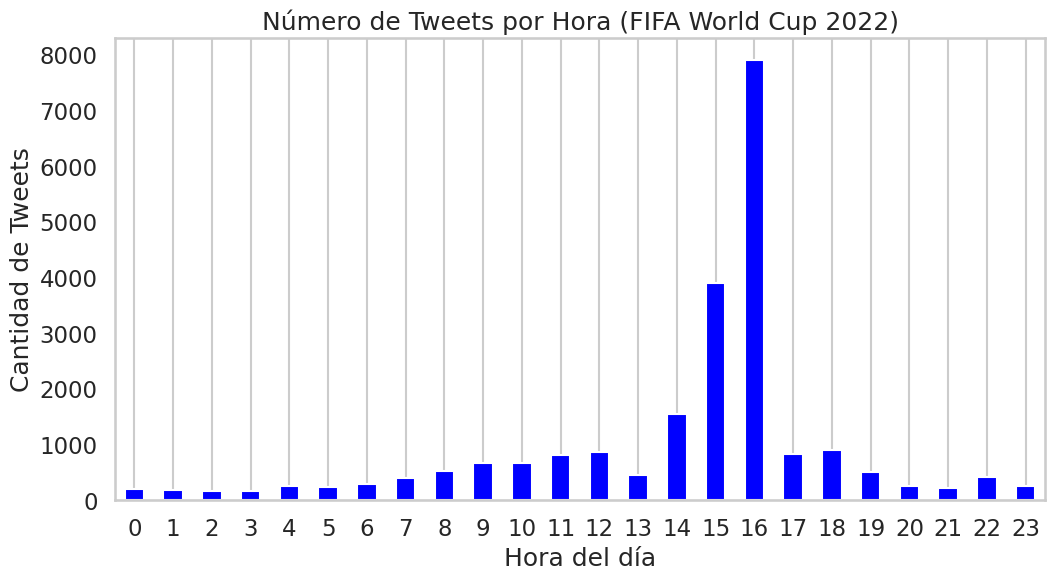

In [19]:
# Convertir la columna "Date Created" a datetime
if 'Date Created' in df.columns:
    df['Date Created'] = pd.to_datetime(df['Date Created'], errors='coerce')

    # Eliminar registros sin una fecha válida
    df = df.dropna(subset=['Date Created'])

    # Extraer la hora de los tweets
    df['Hour'] = df['Date Created'].dt.hour

    # Agrupar por hora y contar la cantidad de tweets
    tweets_por_hora = df.groupby('Hour').size()

    plt.figure(figsize=(12, 6))
    tweets_por_hora.plot(kind='bar', color='blue')
    plt.title("Número de Tweets por Hora (FIFA World Cup 2022)")
    plt.xlabel("Hora del día")
    plt.ylabel("Cantidad de Tweets")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()
else:
    print("Error: La columna 'Date Created' no está en el DataFrame.")

Distribución de Sentimientos (Ground Truth)

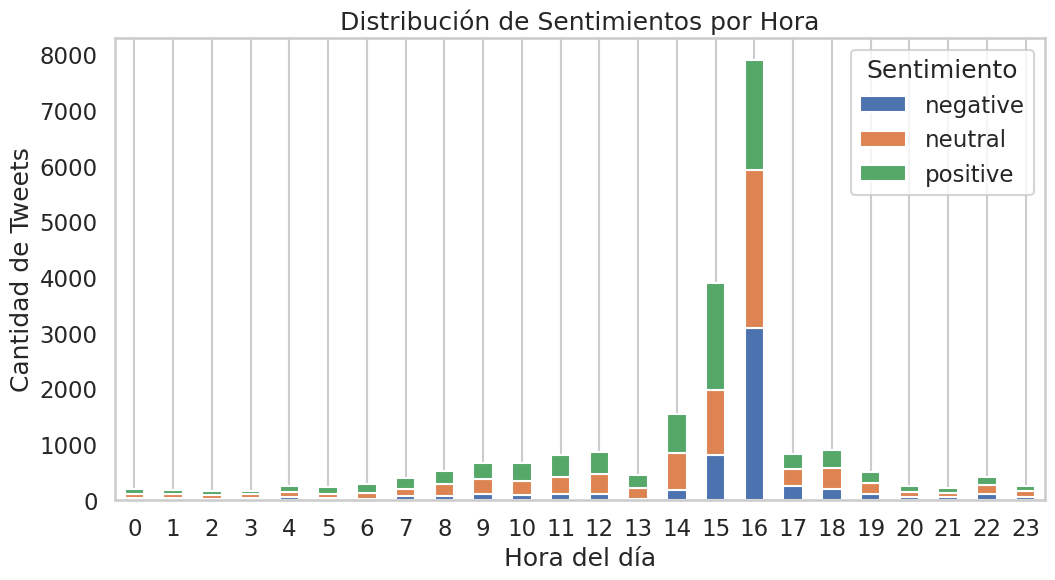

In [20]:
if 'Sentiment' in df.columns:
    sentiment_counts = df.groupby(['Hour', 'Sentiment']).size().unstack()
    sentiment_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title("Distribución de Sentimientos por Hora")
    plt.xlabel("Hora del día")
    plt.ylabel("Cantidad de Tweets")
    plt.legend(title="Sentimiento")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

## Análisis de sentimientos

Analizamos los sentimientos con VADER:

Distribución de sentimientos (VADER):
sentimiento_vader
positivo    9776
neutral     8670
negativo    4078
Name: count, dtype: int64


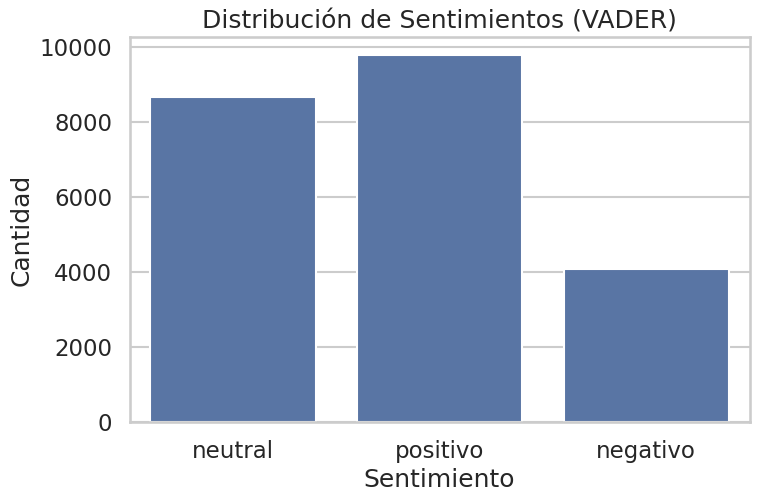

In [25]:
# Inicializar el analizador de VADER
analyzer = SentimentIntensityAnalyzer()

def obtener_sentimiento(texto):
    puntaje = analyzer.polarity_scores(texto)
    if puntaje['compound'] >= 0.05:
        return 'positivo'
    elif puntaje['compound'] <= -0.05:
        return 'negativo'
    else:
        return 'neutral'

# Aplicar VADER al texto limpio
df['sentimiento_vader'] = df['texto_limpio'].apply(obtener_sentimiento)

# Mostrar la distribución de sentimientos según VADER
print("Distribución de sentimientos (VADER):")
print(df['sentimiento_vader'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='sentimiento_vader', data=df.reset_index())
plt.title("Distribución de Sentimientos (VADER)")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad")
plt.show()

## Extracción de tópicos y visualización

Extraemos los tópicos con LDA.

In [24]:
# Vectorización con CountVectorizer
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = count_vectorizer.fit_transform(df['texto_limpio'])

# Configurar LDA
num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

def mostrar_top_palabras(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Tópico {idx+1}:")
        palabras_clave = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(palabras_clave)
        print()

# Mostrar las palabras clave de cada tópico
print("Palabras clave de cada tópico:")
mostrar_top_palabras(lda, count_vectorizer.get_feature_names_out(), 10)


Palabras clave de cada tópico:
Tópico 1:
qatar fifaworldcup qatarworldcup football jungkook ecuador opening match lets game

Tópico 2:
qatar football im like know dont today watch let going

Tópico 3:
team fifaworldcup win england football qatar qatarworldcup good argentina brazil

Tópico 4:
world cup qatar fifa opening fifaworldcup ceremony live qatarworldcup vs

Tópico 5:
qatar ecuador goal offside var qatecu fifaworldcup valencia qatarworldcup minutes



Visualizamos los tópicos en los tweets:

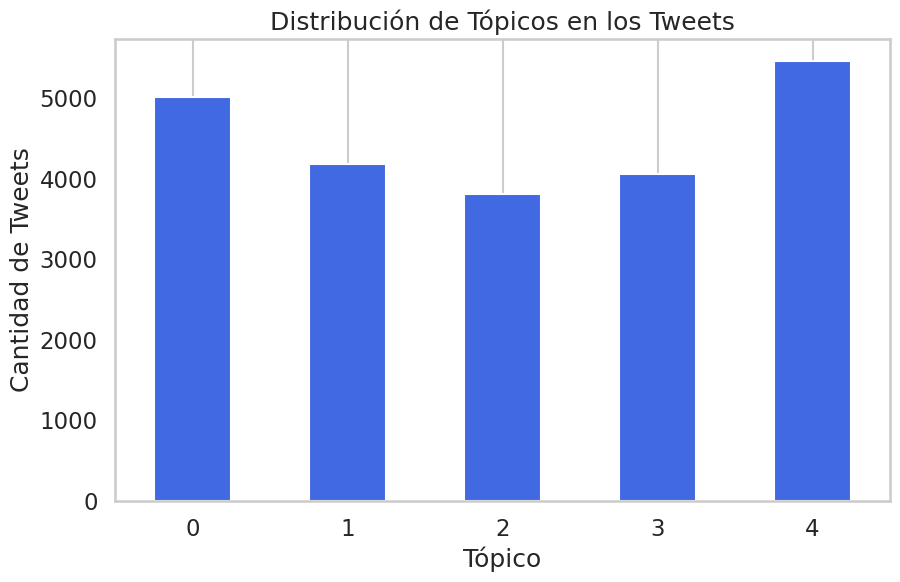

In [28]:
# Obtener el tópico dominante para cada tweet
topic_assignments = lda.transform(dtm)
df['Dominant Topic'] = np.argmax(topic_assignments, axis=1)

# Contar la cantidad de tweets por tópico
topic_counts = df['Dominant Topic'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', color='royalblue')
plt.title("Distribución de Tópicos en los Tweets")
plt.xlabel("Tópico")
plt.ylabel("Cantidad de Tweets")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

Visualizamos los tópicos en la nube de palabras:

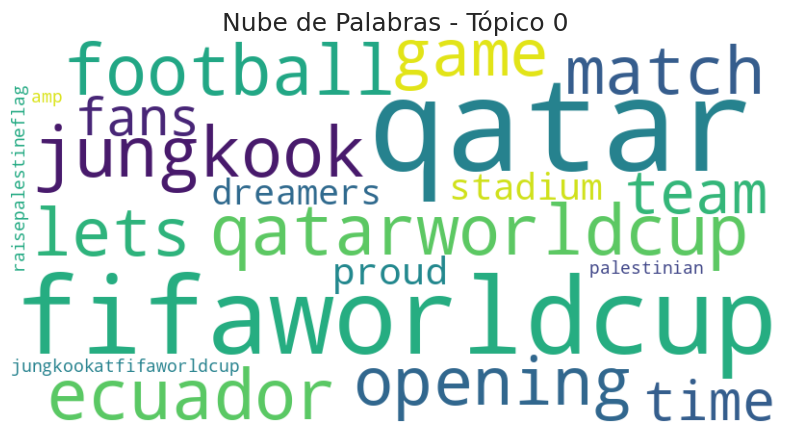

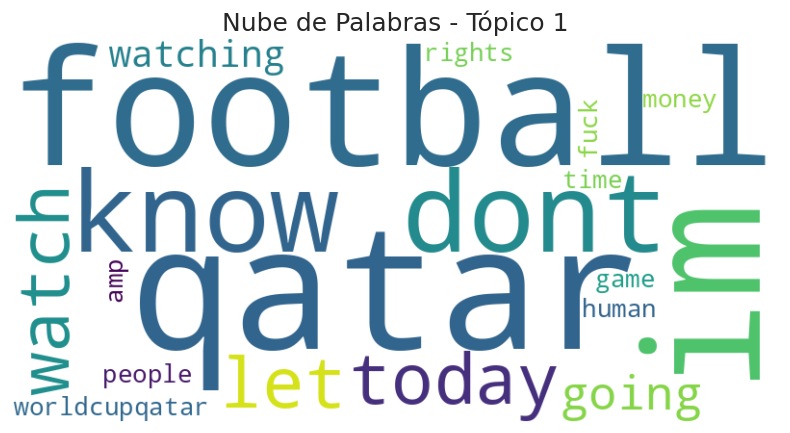

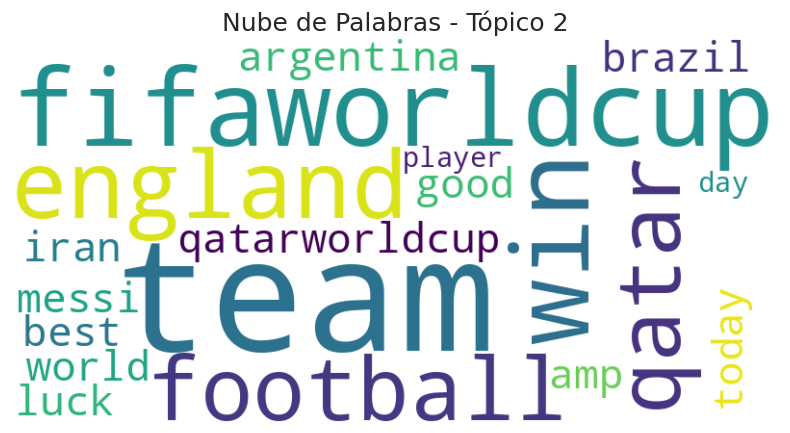

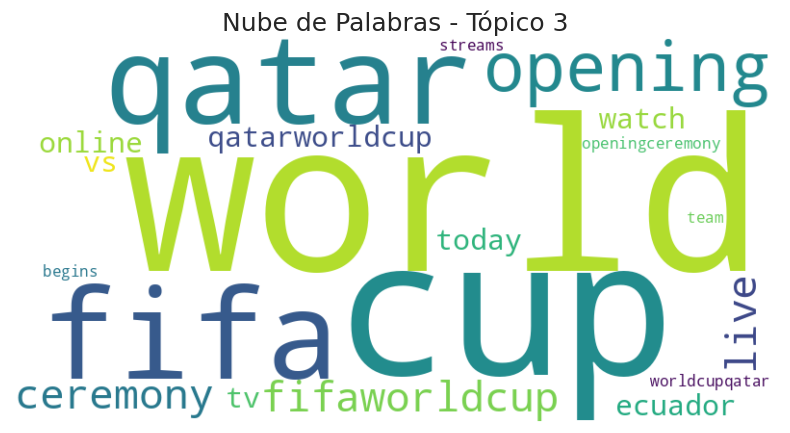

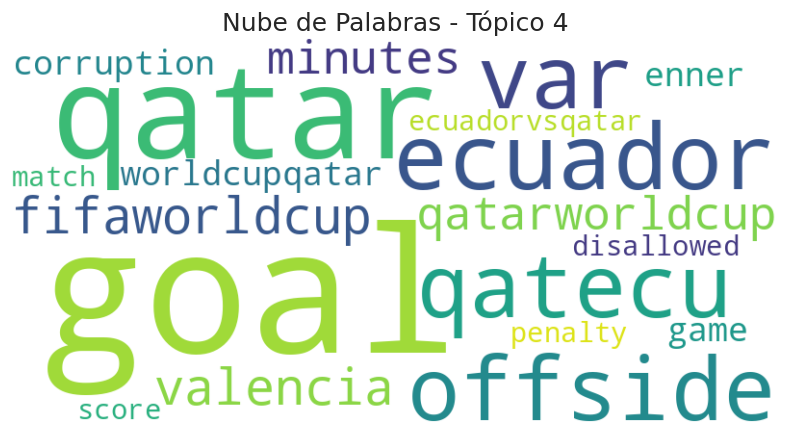

In [30]:
# Crear nubes de palabras para cada tópico
for topic_idx in range(num_topics):
    words = " ".join([count_vectorizer.get_feature_names_out()[i] for i in lda.components_[topic_idx].argsort()[:-20 - 1:-1]])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Nube de Palabras - Tópico {topic_idx}")
    plt.show()

Analizamos los sentimientos por tópico:

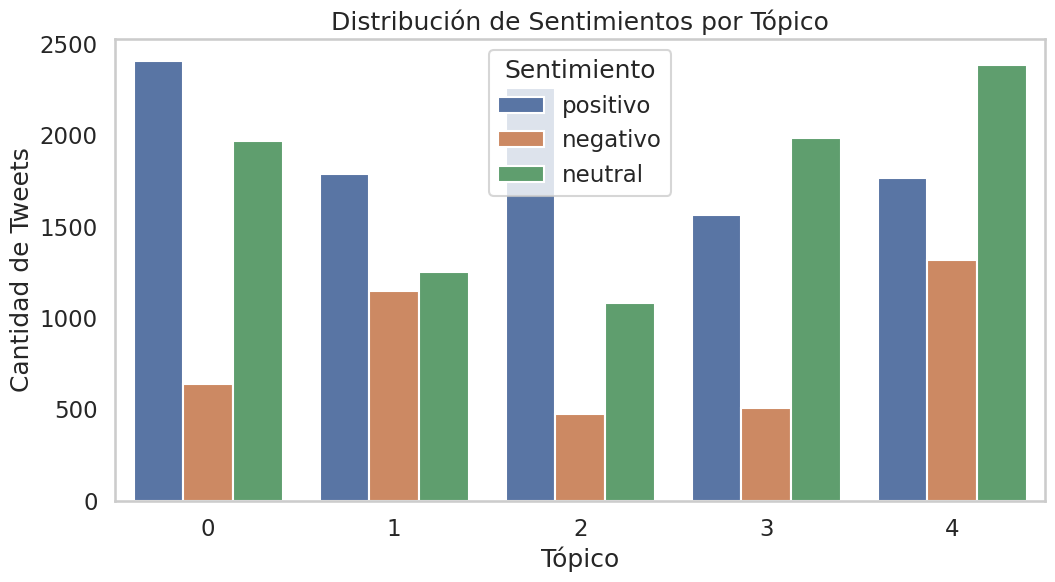

In [32]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Dominant Topic', hue='sentimiento_vader', data=df)
plt.title("Distribución de Sentimientos por Tópico")
plt.xlabel("Tópico")
plt.ylabel("Cantidad de Tweets")
plt.legend(title="Sentimiento")
plt.grid(axis='y')
plt.show()

## Otros análisis

### Análisis de sentimiento por dispositivo

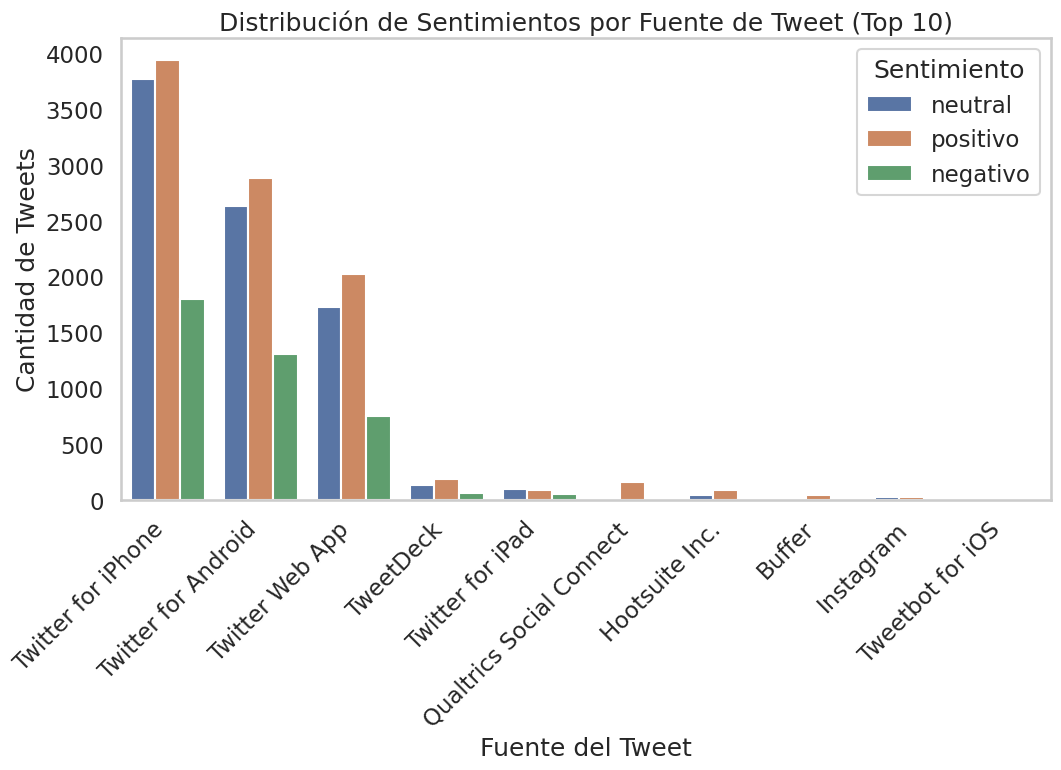

In [37]:
top_sources = df['Source of Tweet'].value_counts().nlargest(10).index

plt.figure(figsize=(12, 6))
sns.countplot(x='Source of Tweet', hue='sentimiento_vader', data=df[df['Source of Tweet'].isin(top_sources)], order=top_sources)
plt.title("Distribución de Sentimientos por Fuente de Tweet (Top 10)")
plt.xlabel("Fuente del Tweet")
plt.ylabel("Cantidad de Tweets")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Sentimiento")
plt.grid(axis='y')
plt.show()

### Análisis de la longitud de los tweets y su sentimiento

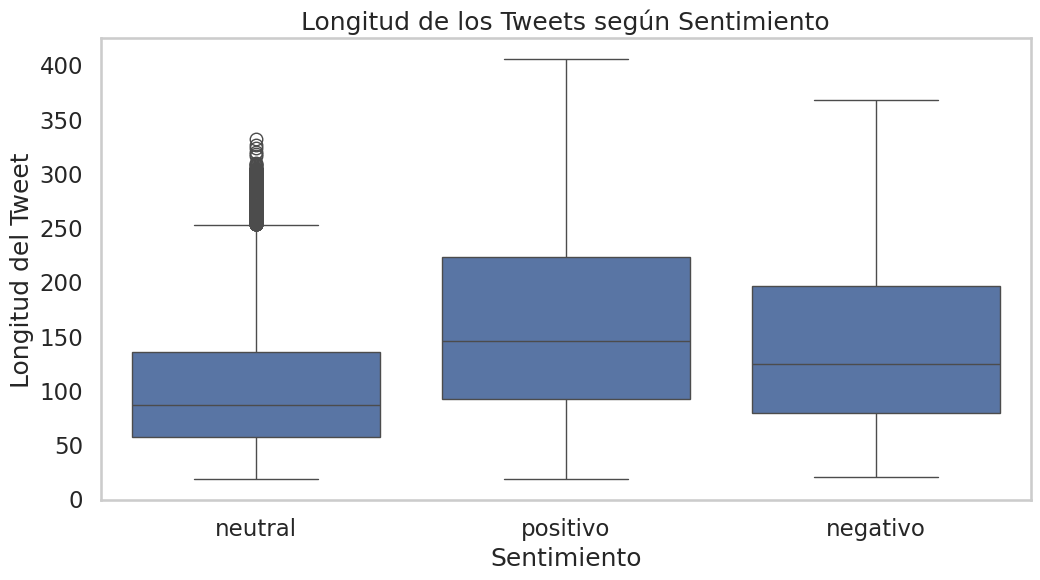

In [38]:
df['tweet_length'] = df['Tweet'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(x='sentimiento_vader', y='tweet_length', data=df)
plt.title("Longitud de los Tweets según Sentimiento")
plt.xlabel("Sentimiento")
plt.ylabel("Longitud del Tweet")
plt.grid(axis='y')
plt.show()

### Frecuencia de palabras Positivas vs Negativas

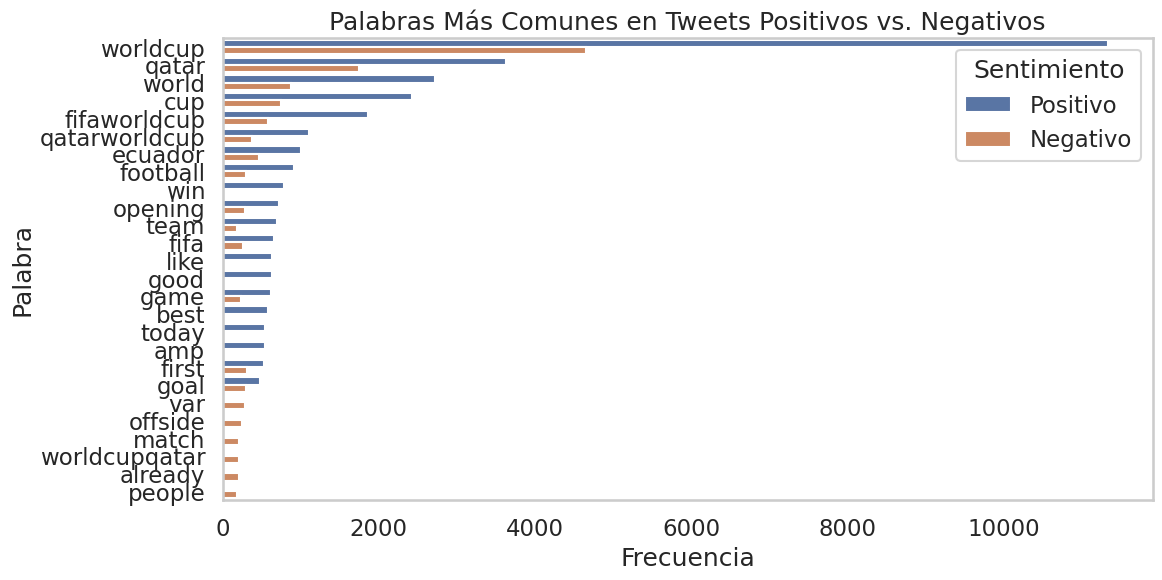

In [40]:
from collections import Counter

def obtener_palabras(textos):
    palabras = " ".join(textos).split()
    return Counter(palabras).most_common(20)

# Obtener palabras más comunes por sentimiento
positivas = obtener_palabras(df[df['sentimiento_vader'] == 'positivo']['texto_limpio'])
negativas = obtener_palabras(df[df['sentimiento_vader'] == 'negativo']['texto_limpio'])

# Convertir a DataFrame para graficar
df_palabras = pd.DataFrame({
    'Palabra': [p[0] for p in positivas + negativas],
    'Frecuencia': [p[1] for p in positivas + negativas],
    'Sentimiento': ['Positivo'] * len(positivas) + ['Negativo'] * len(negativas)
})

plt.figure(figsize=(12, 6))
sns.barplot(x='Frecuencia', y='Palabra', hue='Sentimiento', data=df_palabras)
plt.title("Palabras Más Comunes en Tweets Positivos vs. Negativos")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.legend(title="Sentimiento")
plt.grid(axis='x')
plt.show()

### Relación entre likes y sentimiento

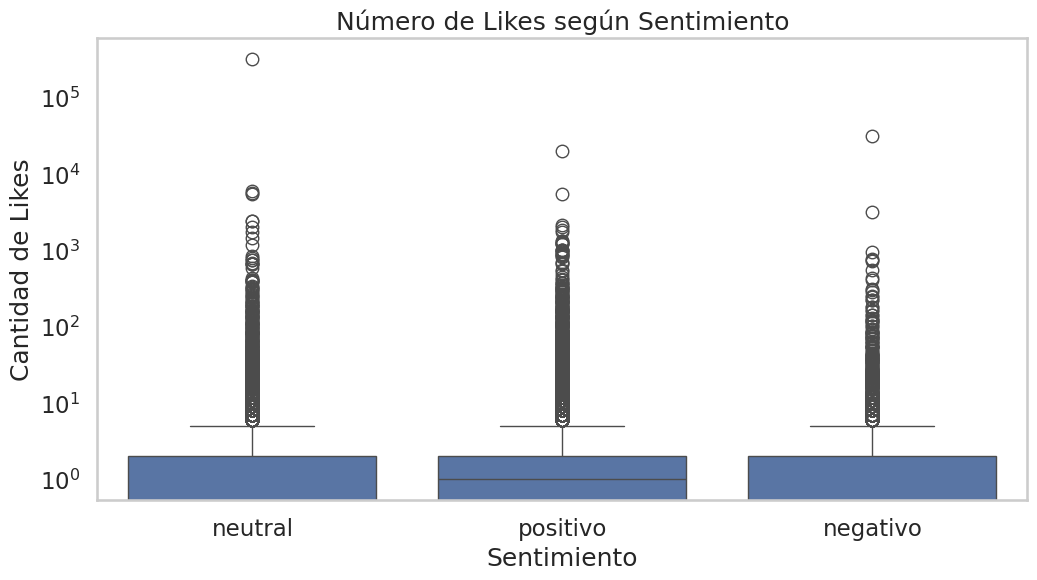

In [43]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentimiento_vader', y='Number of Likes', data=df)
plt.yscale('log')  # Escala logarítmica para mejor visualización
plt.title("Número de Likes según Sentimiento")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de Likes")
plt.grid(axis='y')
plt.show()

### Análisis de Hastags más usados

/tmp/ipykernel_1915/4018134998.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Hashtag', x='Frecuencia', data=df_hashtags, palette="viridis")


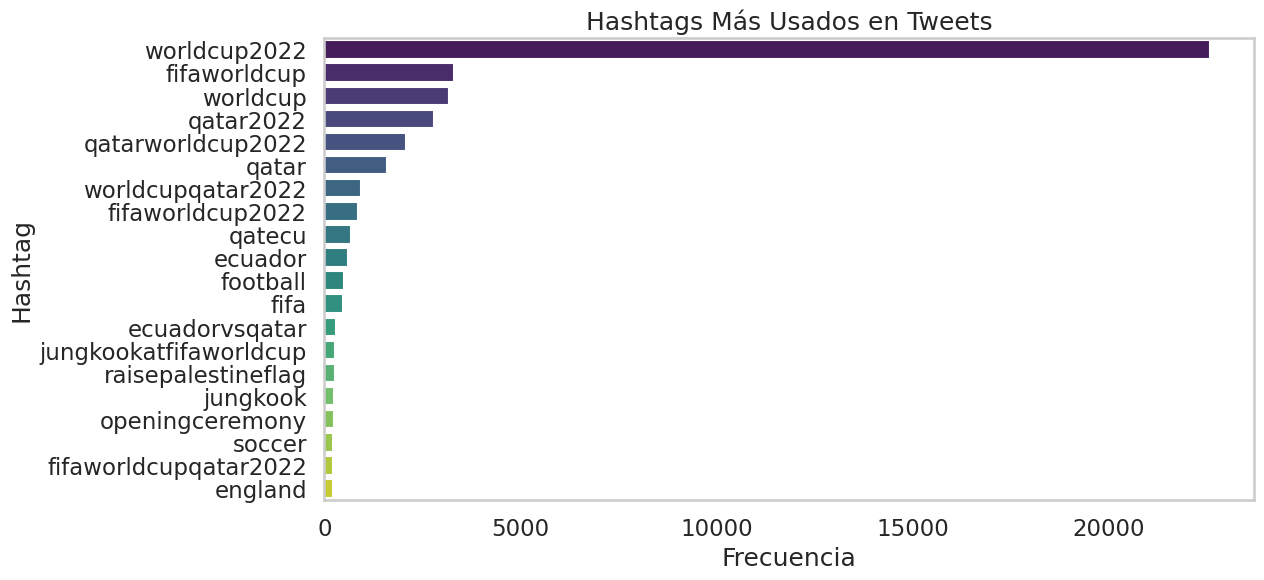

In [47]:
from collections import Counter
import re

# Extraer hashtags de los tweets
df['hashtags'] = df['Tweet'].apply(lambda x: re.findall(r"#(\w+)", x.lower()))

# Contar los hashtags más usados
hashtags_totales = Counter([hashtag for hashtags in df['hashtags'] for hashtag in hashtags]).most_common(20)

# Convertir a DataFrame para graficar
df_hashtags = pd.DataFrame(hashtags_totales, columns=['Hashtag', 'Frecuencia'])

plt.figure(figsize=(12, 6))
sns.barplot(y='Hashtag', x='Frecuencia', data=df_hashtags, palette="viridis")
plt.title("Hashtags Más Usados en Tweets")
plt.xlabel("Frecuencia")
plt.ylabel("Hashtag")
plt.grid(axis='x')
plt.show()

### Identificación de tweets más virales

In [61]:
import textwrap

# Asegurar que 'Number of Likes' sea numérico
df['Number of Likes'] = pd.to_numeric(df['Number of Likes'], errors='coerce').fillna(0)

# Ordenar los tweets por número de likes
top_tweets = df[['Tweet', 'Number of Likes', 'Sentiment', 'Date Created']].sort_values(by="Number of Likes", ascending=False).head(10)

# Mostrar los 10 tweets más virales
for i, row in top_tweets.iterrows():
    fecha_str = row['Date Created'].strftime('%Y-%m-%d') if pd.notna(row['Date Created']) else "Fecha Inválida"
    print(f"Tweet ({row['Sentiment'].capitalize()} - {int(row['Number of Likes'])} Likes - {fecha_str}):")
    print(textwrap.fill(row['Tweet'], width=80))  # Ajusta el ancho del texto para mejor legibilidad
    print("-" * 100)

Tweet (Positive - 316867 Likes - 1970-01-01):
I can’t express my gratitude and happiness for my participation in the biggest
event of all times the World Cup in my country #Qatar with the talented Jung
kook , thank you for everything #WorldCup  #WorldCup2022  #JUNGKOOKxFIFA
#JungkookAtFIFAWorldCup  @BTS_twt  @bts_bighit https://t.co/PebpCj9uN2
----------------------------------------------------------------------------------------------------
Tweet (Neutral - 31517 Likes - 1970-01-01):
Football Legend Eric Cantona reminds football fans: "Let's not forget Julian
Assange. A journalist jailed in England for publishing war crimes"
#FreeAssangeNOW #WorldCup2022 https://t.co/upIvupMErv
----------------------------------------------------------------------------------------------------
Tweet (Positive - 20016 Likes - 1970-01-01):
⚽️ #BitKeep FootBall Carnival Main Event is coming⚽️  🥳 Trading activity &amp;
Community quiz 🥳  📅Nov 21 - Dec 20 ✅Join our TG &amp; Download BitKeep to win
token re

In [64]:
# Calcular el sentimiento absoluto (lejos del 0 es más extremo)
df['Sentimiento Absoluto'] = df['Sentiment']

# Ordenar por número de likes y sentimiento extremo
top_controversial = df.sort_values(by=['Sentimiento Absoluto', 'Number of Likes'], ascending=[False, False]).head(10)

# Mostrar los tweets más polémicos
import textwrap
for i, row in top_controversial.iterrows():
    print(f"Tweet ({row['Sentiment'].capitalize()} - {int(row['Number of Likes'])} Likes):")
    print(textwrap.fill(row['Tweet'], width=80))
    print("-" * 100)

Tweet (Positive - 316867 Likes):
I can’t express my gratitude and happiness for my participation in the biggest
event of all times the World Cup in my country #Qatar with the talented Jung
kook , thank you for everything #WorldCup  #WorldCup2022  #JUNGKOOKxFIFA
#JungkookAtFIFAWorldCup  @BTS_twt  @bts_bighit https://t.co/PebpCj9uN2
----------------------------------------------------------------------------------------------------
Tweet (Positive - 20016 Likes):
⚽️ #BitKeep FootBall Carnival Main Event is coming⚽️  🥳 Trading activity &amp;
Community quiz 🥳  📅Nov 21 - Dec 20 ✅Join our TG &amp; Download BitKeep to win
token rewards  A reward pool of $100,000 is waiting for you!   Details:
👉https://t.co/LFSC3g6NJO... #Giveaways  #WorldCup2022 https://t.co/dVuRl2Dgut
----------------------------------------------------------------------------------------------------
Tweet (Positive - 5555 Likes):
The 👑 Leo with Louis Vuitton 💧 #WorldCup2022 https://t.co/gfdXhgxtXl
--------------------------

## Clustering de tweets según su contenido

Vectorización de los tweets

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Vectorizar los tweets con TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['Tweet'])

print("Dimensión de la matriz TF-IDF:", X.shape)  # Ver tamaño de la matriz


Dimensión de la matriz TF-IDF: (22524, 1000)


Usamos K-Means para crear grupos de tweets similares

In [68]:
# Definir el número de clusters
num_clusters = 5  # Podemos cambiar este valor si es necesario

# Aplicar K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X)

# Mostrar el número de tweets en cada cluster
print(df['Cluster'].value_counts())

Cluster
0    10302
2     4159
4     3733
3     3667
1      663
Name: count, dtype: int64


Análisis de las palabras más representativas por cluster

In [69]:
# Obtener los centroides de los clusters
centroides = kmeans.cluster_centers_

# Obtener las palabras clave más importantes de cada cluster
def mostrar_palabras_importantes(vectorizer, kmeans, n_palabras=10):
    palabras = np.array(vectorizer.get_feature_names_out())
    for i, centroide in enumerate(kmeans.cluster_centers_):
        palabras_importantes = palabras[np.argsort(centroide)[-n_palabras:]]
        print(f"\n🔹 **Cluster {i}:**")
        print(", ".join(palabras_importantes))

# Mostrar palabras clave de cada cluster
mostrar_palabras_importantes(vectorizer, kmeans)


🔹 **Cluster 0:**
football, worldcup, opening, let, https, fifaworldcup, var, goal, offside, worldcup2022

🔹 **Cluster 1:**
bts_twt, dreamers2022, bts, dreamers, worldcup2022, https, dreamersbyjungkook, proud, jungkookatfifaworldcup, jungkook

🔹 **Cluster 2:**
match, qatarworldcup2022, worldcup, qatar2022, fifaworldcup, goal, https, worldcup2022, ecuador, qatar

🔹 **Cluster 3:**
worldcup, fifaworldcup, opening, qatar, fifa, worldcup2022, https, 2022, world, cup

🔹 **Cluster 4:**
today, ready, let, football, qatarworldcup2022, qatar2022, fifaworldcup, worldcup, worldcup2022, https


In [70]:
for cluster in range(num_clusters):
    print(f"\n🔹 **Ejemplos de Tweets en el Cluster {cluster}:**")
    print(df[df['Cluster'] == cluster]['Tweet'].sample(3, random_state=42).to_string(index=False))


🔹 **Ejemplos de Tweets en el Cluster 0:**
#WorldCup2022 how much did that decision cost #...
Refreshing to see the Palestine flag flying glo...
                            I BTS…?\n#WorldCup2022

🔹 **Ejemplos de Tweets en el Cluster 1:**
I’m so proud of you &lt;3 #JungkookAtFIFAWorldC...
Jung Kook - Dreamers (FIFA World Cup Qatar 2022...
@benm_1999_ Hi, your ️#WorldCup2022 is now avai...

🔹 **Ejemplos de Tweets en el Cluster 2:**
Ecuador and Qatar usher in #WorldCup2022 here i...
#محمد_بن_سلمان_في_قطر \n#كأس_العالم_قطر_2022 \n...
The hypocrisy of these British broadcasters is ...

🔹 **Ejemplos de Tweets en el Cluster 3:**
2022 FIFA World Cup Opening Ceremony Live Strea...
Sad day Karim Benzema out of the world cup beca...
Are you Excited? Because we are!! \nThe FIFA 20...

🔹 **Ejemplos de Tweets en el Cluster 4:**
I’m so happy #WorldCup2022 Cup is coming! https...
Today is the day #WorldCup2022 #FIFAWorldCup ht...
We are live at the lugogo hockey grounds for #W...
